<a href="https://colab.research.google.com/github/danielsaggau/Elections-Belarus/blob/main/Belarus_ML_Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleansing 

In the first part of this analysis, we need to undertake some pre-processing steps. 


In [3]:
import pandas as pd
import numpy as np
df_pls=pd.read_excel("df_merge_n.xlsx")

In [ ]:
df_pls_pls=df_pls.drop(columns=['Unnamed: 0'])
df_pls_pls=df_pls_pls.fillna(0)
df_pls_new=df_pls_pls.drop(columns=['commission_code','number_of_cite'])
df_pls_new.info()

In [ ]:
df_merge1=df_pls_new.drop(columns=['attachment1','attachment2','attachment3','attachment4','attachment5','comment','id','type','name','location','origin','area'])
df_merge1.info()

# Feature Engineering 
We can now calculate the share of votes for Lukashenko. 

In [ ]:
df_merge1['lukashenko_share']=df_merge1['Lukashenko']/df_merge1['number_of_voters_who_took_part_in_the_voting']
df_merge1['lukashenko_share']=df_merge1['lukashenko_share'].replace([np.inf, -np.inf], 0)
df_merge1.info()

Now, we can drop some of the obsolete columns. 

In [10]:
df_merge2=df_merge1.drop(columns=['parent_id','description_x','commission_id','work_title','description_y','city_or_district_within_the_region','area_in_the_city','settlement'])

In [ ]:
df_merge2.columns

In [ ]:
df_merge2['region'].unique()

Next we need to rename the regions and change no region to 0: 

In [13]:
df_merge2['region']=df_merge2['region'].replace('Брестская','brestskaya')
df_merge2['region']=df_merge2['region'].replace('Витебская','vitebskaya')
df_merge2['region']=df_merge2['region'].replace('Гомельская','gomelskaya')
df_merge2['region']=df_merge2['region'].replace('Гродненская','grodnenskaya')
df_merge2['region']=df_merge2['region'].replace('Минская','miskaya')
df_merge2['region']=df_merge2['region'].replace('Могилевская','mogilevskaya')
df_merge2['region']=df_merge2['region'].replace('город Минск','minsk')
df_merge2.region=df_merge2.region.replace(0, 'no_region')

Based on this variable, we can craete dummy variables for each region. 

In [14]:
df_merge3=pd.get_dummies(df_merge2, 'region')

We can save this dataset as an intermediate dataset.
We also save a version without the region dummies for the regression analysis thereafter, due to the limited number of observations for some regions that could become problematic later on.

In [ ]:
df_merge3.info()
df_merge3=df_merge3.fillna(0)
df_merge_d=df_merge3.fillna(0)
df_merge_d.to_excel("df_merge_d.xlsx")

# Random Forest for Feature Selection 

In this section we use a random forest for feature selection.
This section is structured as follows:

1. Specifying our model structure and removing variables that are not needed or variables that should be included for the prediction  
2. Splitting the data set into training and test set 
3. Running the algorithm, using cross validation
4. Plot the feature importance per feature 

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Splitting the Dataset and specifying our dependent Variable



In [17]:

# обязательный код
X=df_merge3.drop(columns=['lukashenko_share','Dmitriev','Kanopatskaya','Lukashenko','Tikhanovskaya','Cherechen']).values
y=df_merge3.lukashenko_share.values
# сплитуйте X и y как хотите
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, 
                                                    shuffle=True)

Next we can instantiate our RF regressor.

In [ ]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1600, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_
y_pred=rf_random.predict(X_test)
print('Правильность на обучающем наборе: {:.5f}'.format(rf_random.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.5f}'.format(rf_random.score(X_test, y_test)))

In [ ]:
importance_values=rf_random.best_estimator_.feature_importances_

In [ ]:
importances = rf_random.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [ ]:
feature_importance_labels=df_merge3.drop(columns=['lukashenko_share','Dmitriev', 'Kanopatskaya', 'Lukashenko', 'Tikhanovskaya', 'Cherechen'])

In [ ]:
column_names=list(feature_importance_labels.columns)

In [ ]:
column_names

In [ ]:
values_imp=list(importance_values)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
 
courses = ['total','receiv','tookpart','earlvoting','residence','electday','dur_earl_vot','againts_all','held_on','invalid','rec_comm','spoiled','unusedb','latitude','longitude','doctor','army','education','science','prof_union','economics','brest','gomel', 'grod','minsk','miskaya','mogilev','no_region','vitebsk']
values = values_imp

plt.bar(courses, values, color ='blue')

plt.xticks(rotation = 60)
plt.show()

In [ ]:
df_merge3.isna().sum()


# Feature Selection, Regression Analysis and Exploratory Data Analysis in R
We undertake the regression models in R. 
The following sections are structured as follows: 

1.   Lasso Regression compared to a naive model 
2.   Regression model with the selected features for LASSO
3.   Regression model with the selected features for the random forest 
4.   Feature importance in lasso regression compared to the random forest.  
5.   Exploration of unsupervised learning methods Part 1: Principal Component Analysis 
6.   Exploration of unsupervised learning methods Part 2: Latent Dirichlet Allocation 
7.   Geospatial Analysis of Voting Behaviour 

Prior to including R code, we need to install 'rpy2' package.
Further, every cell needs to start with %%R for the Markdown file to differentiate between R code and Python code.

In [23]:
!pip install rpy2
%load_ext rpy2.ipython

## LASSO Regression for Feature Selection

In the first step we need to install our packages and set our seed for replicability.

In [ ]:
%%R

install.packages("skimr")
install.packages("glmnet")
install.packages("plotmo")

library(readxl)
library(MASS)
library(tidyverse)
library(broom)
library(skimr)
library(glmnet)
library(plotmo)
set.seed(144)

## Splitting the data 

In the first step, we split the data into training and test set. 
We use a split of 0.66.
For reference, we are using a slightly modified dataset here because we use regression as a categorical variable and not use dummies for each region due to the limited number of observations which prove to be inconvient for subsequent regression analysis. Irrespective, we will later on look at geospatial voting information to get a more fine grained picture of what the geospatial variation looks like. 

In [342]:
%%R
data = read_excel("df_merge_d.xlsx")
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen")) # removing other candidate votes
colnames(data)[1:12] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")
data = data[c(24:31,1:23)] # reorder variables
data = data[c(30, 1:29, 31)]

p = ncol(data) -1
n <- nrow(data)
ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 

R[write to console]: New names:
* `` -> ...1



Now we can also look at some summary statistics.
Optionally, we can also look at summary statistics itself using the summary command, but some recent data exploration packages allow for a more interesting look at different variables also plotting 

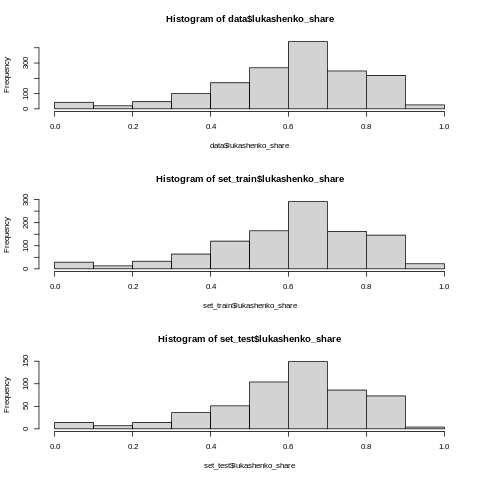

In [119]:
%%R
par(mfrow = c(3, 1))
hist(data$lukashenko_share) 
hist(set_train$lukashenko_share)
hist(set_test$lukashenko_share)

In [ ]:
skim(set_train)

## Correlation Plot

Next we can also look at the correlation plot

In [ ]:
%%R
install.packages("corrplot")
library(corrplot)

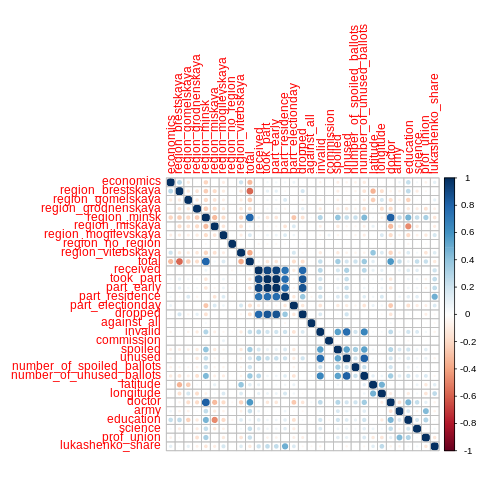

In [295]:
%%R
correl = cor(data)
corrplot(correl)

# Naive Regression Model

In [ ]:
%%R
model_naive = lm(lukashenko_share~., data = set_train)
summary(model_naive)

# Lasso Model 


In [297]:
%%R
model_lasso = glmnet(x = as.matrix(set_train[,-(p+1)]), y = set_train$lukashenko_share, alpha =1)

## Cross Validation 


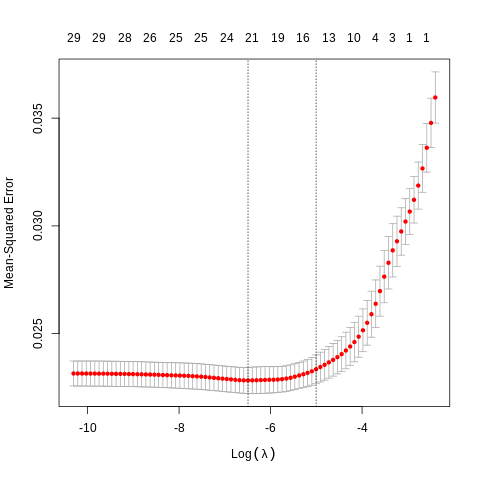

In [298]:
%%R
cv<-cv.glmnet(as.matrix(set_train[-(p+1)]), y= set_train$lukashenko_share,alpha =1, nfolds = 3) 
plot(cv)

## Selecting the optimal Lambda parameter

[1] 0.001513533


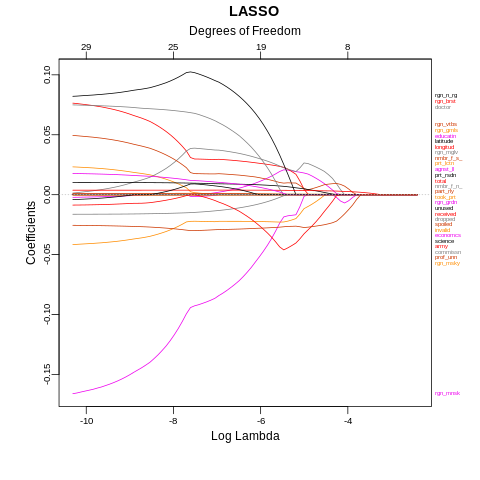

In [301]:
%%R

lambda_lasso = cv.glmnet(x = as.matrix(set_train[,-(p+1)]),y = set_train$lukashenko_share, alpha =1)$lambda.min

# Plot log lambda
plot_glmnet(x = model_lasso, label = TRUE, xvar = "lambda")
title(main = "LASSO", line = 3)
lambda_lasso

## Optional : More Iterations 
This step is optional. 
We can optionally also run various cross validation splits. Here we do 100 iterations. 

In [302]:
%%R
MSEs <- NULL
for (i in 1:100){
                 cv= cv.glmnet(x= as.matrix(set_train[,-(p+1)]), y= set_train$lukashenko_share, alpha =1) 
                 MSEs <- cbind(MSEs, cv$cvm)
             }
  rownames(MSEs) <- cv$lambda
  lambda.min <- as.numeric(names(which.min(rowMeans(MSEs))))
  lambda.min

[1] 0.001256561



We can first look at how our models perform on our training data.
Here we are comparing a random forest and a lasso model. 

In [304]:
%%R
y_train = set_train$lukashenko_share
predict_train = matrix(data =0, nrow= nrow(set_train), ncol=2)

predict_train[, 1] = predict(object = model_naive, newdata = set_train[, -(p + 1)])
predict_train[,2] = predict.glmnet(object = model_lasso, 
                                  newx = as.matrix(set_train[,-(p + 1)]),
                                  s = lambda_lasso)

colnames(predict_train) =c("Naive Model", "Lasso Model")

In [305]:
%%R
MSE_train = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_train[i] = mean((y_train-predict_train[,i])^2)
}
names(MSE_train) = c("Naive Model", "Lasso Model")
MSE_train

Naive Model Lasso Model 
 0.02122571  0.02138466 


Predicting on our training data, we can see that the OLS model without regularization performs better than the Lasso model, although they are somewhat similar. 
Subsequently, we can look at how our model performs when dealing with new data. 
Therefore, we use the test set and again predict our naive and our lasso model.

In [306]:
%%R
y_test = set_test$lukashenko_share
predict_test = matrix(data =0, nrow= nrow(set_test), ncol=2)

predict_test[, 1] = predict(object = model_naive, newdata = set_test[, -(p + 1)])
predict_test[,2] = predict.glmnet(object = model_lasso,  newx = as.matrix(set_test[,-(p+1)]),
                                  s = lambda_lasso)

colnames(predict_test) =c("Naive Model", "Lasso Model")

MSE_test = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_test[i] = mean((y_test-predict_test[,i])^2)
}
names(MSE_test) = c("Naive Model", "Lasso Model")
MSE_test

Naive Model Lasso Model 
 0.02290487  0.02273377 


# Feature Importance for Lasso Regression 
 
 For comparability, we also include 

In [ ]:
%%R
set.seed(123)
install.packages("ranger")
install.packages("vip")
library(ranger)
library(vip) # Link: https://koalaverse.github.io/vip/articles/vip.html

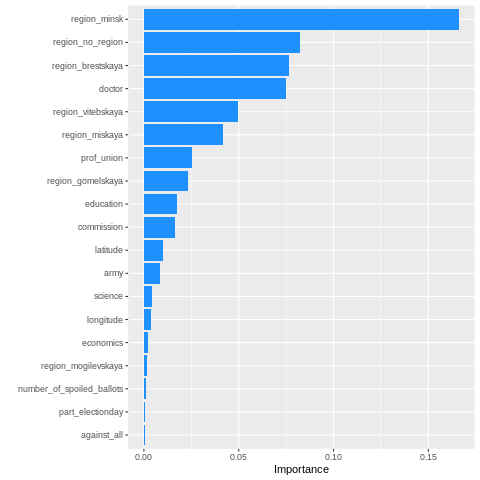

In [313]:
%%R
# backward <- step(model_lasso, direction = "backward", trace = 0)
vip(model_lasso, width = 0.5, aesthetics = list(fill = "dodgerblue1"), num_features= 19)

# OLS Regression with selected features

Here we can see a very different performance. 
The Lasso model performs substantially better then the OLS model.
Therefore, using this method has led to better predictive performance. 
Lastly, we can also use the lasso specification for a OLS model, trained on test data to ensure that we have no incorrect standard errors.
This is a pivotal concern within in economics, because we need correct standard errors to interpret our coefficients and ensure causality. 

As a first step we can look at the coefficients in the lasso model:

In [ ]:
%%R
coef_lasso <- model_lasso$beta[, which(model_lasso$lambda == lambda_lasso)]
which(coef_lasso!=0)

The advantage of the lasso method is that we induce sparsity.
Here we can see that various features turn to 0.
One could also argue that due to correlation between some features, explanatory or variance was ascribed to either the one or the other variable. 
We can see that the variables that were more correlated (see correlation plot above) frequently scored 0 here. 
Now we can specify a model with the relevant coefficients, and run the model on the test data. 

In [315]:
%%R
model = lm(lukashenko_share ~  region_brestskaya + region_minsk +  region_mogilevskaya + region_no_region +region_vitebskaya  + part_residence + part_electionday + dropped + invalid + unused + number_of_spoiled_ballots + latitude +longitude + doctor + army  +  education  + prof_union +economics, data = set_test)  
summary(model)


Call:
lm(formula = lukashenko_share ~ region_brestskaya + region_minsk + 
    region_mogilevskaya + region_no_region + region_vitebskaya + 
    part_residence + part_electionday + dropped + invalid + unused + 
    number_of_spoiled_ballots + latitude + longitude + doctor + 
    army + education + prof_union + economics, data = set_test)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.54772 -0.08241  0.01056  0.09090  0.40180 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                7.227e-01  3.401e-01   2.125 0.034096 *  
region_brestskaya          7.355e-02  2.477e-02   2.970 0.003117 ** 
region_minsk              -3.734e-02  4.208e-02  -0.887 0.375300    
region_mogilevskaya        4.700e-02  2.546e-02   1.846 0.065473 .  
region_no_region          -5.271e-02  1.504e-01  -0.350 0.726227    
region_vitebskaya          6.958e-02  2.965e-02   2.346 0.019335 *  
part_residence             3.546e-04  2.359e-05  15.033  <

We can see that our R-Squared improved. 
Irrespective, various variables remain which are insignificant. 
One consideration is that feature selection via lasso regression focuses on optimizing the lasso regression and NOT an OLS regression. Henceforth, the optimization problems differ. Further, there is variation between test and train data. 

# Alternative Methods: Unsupervised Learning via Principal Component Analysis 

In addition to supervised learning, we can also look at feature importance from the perspective of unsupervised learning.
One popular dimensionality reduction technique is principal component analysis or in short PCA. 


In [ ]:
%%R
install.packages("ggfortify")
library(ggfortify)

In [356]:
%%R
PCA = prcomp(data, scale. = TRUE,center = TRUE)
summary(PCA)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2102 2.0778 1.50257 1.39913 1.33834 1.23698 1.20293
Proportion of Variance 0.1576 0.1393 0.07283 0.06315 0.05778 0.04936 0.04668
Cumulative Proportion  0.1576 0.2969 0.36968 0.43282 0.49060 0.53996 0.58664
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.10224 1.09559 1.01734 1.00255 0.99884 0.96364 0.95540
Proportion of Variance 0.03919 0.03872 0.03339 0.03242 0.03218 0.02996 0.02944
Cumulative Proportion  0.62583 0.66455 0.69794 0.73036 0.76254 0.79250 0.82194
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.92853 0.89491 0.84489 0.79407 0.72185 0.69192 0.58226
Proportion of Variance 0.02781 0.02583 0.02303 0.02034 0.01681 0.01544 0.01094
Cumulative Proportion  0.84976 0.87559 0.89862 0.91896 0.93577 0.95121 0.96215
                          PC22    

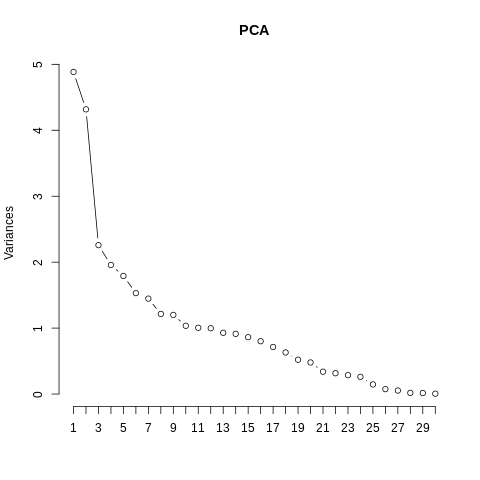

In [347]:
%%R
screeplot(PCA, npcs =30, type = "lines")


## Optional: Further Analysis 

Future analysis could also use further graphical tools to examine variation in subgroups. 

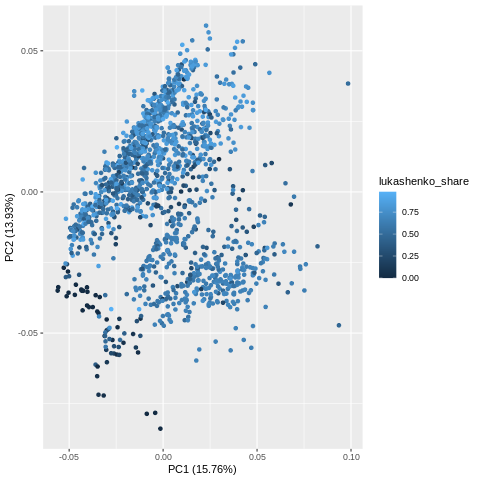

In [363]:
%%R
autoplot(PCA, colour = "lukashenko_share", loadings =F,loading.label =T,loadings.label.size = 20, groups= data$region_minsk)


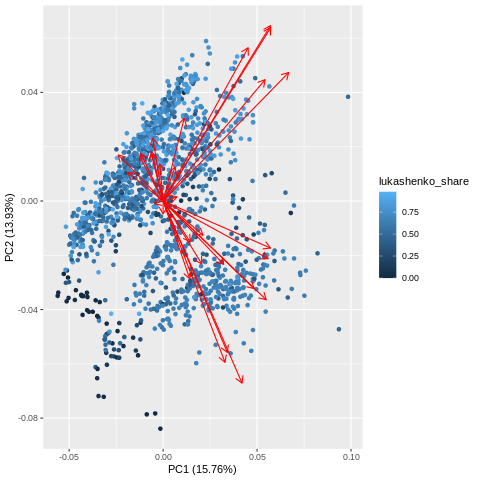

In [364]:
%%R
autoplot(PCA, colour = "lukashenko_share", loadings =T,loading.label =T,loadings.label.size = 20, groups= data$region_minsk)

# Alternative Methods: Unsupervised Learning via Latent Dirichlet Allocation 



In [ ]:
%%R
system2('sudo', 'apt-get install libgsl0-dev')
install.packages("topicmodels")
install.packages("tidytext")
#install.packages("lda")
#install.packages("tm")

install.packages("reshape2")
library(reshape2)
library(tidytext)
library(topicmodels)
library(lda)
library(tm)

In [ ]:
%%R
install.packages("lda")
library(lda)

In [366]:
%%R
data = read_excel("df_merge_n.xlsx")
data = unite(data, col = "text", commission_code:economics, sep =" ")
summary(data)

R[write to console]: New names:
* `` -> ...1



      ...1            text          
 Min.   :   0.0   Length:1583       
 1st Qu.: 395.5   Class :character  
 Median : 791.0   Mode  :character  
 Mean   : 791.0                     
 3rd Qu.:1186.5                     
 Max.   :1582.0                     


## Cleaning the Text data 


In [367]:
%%R
data = data %>%
  select("text")

cleaner <- function(text){
  text <- tolower(text)
  text <- gsub("rt", "", text)
  text <- gsub("@\\w+", "", text)
  text <- gsub("[[:punct:]]", "", text)
  text <- gsub("http\\w+", "", text)
  text <- gsub("amp", " ", text)
  text <- gsub("[ |\t]{2,}", "", text)
  text <- gsub("^ ", "", text)
  text <- gsub(" $", "", text)
  text <- gsub(" +", " ", text)
  text <- gsub("=", " ", text)
  text <- gsub('<.*>', '', enc2native(text))
  text <- unique(text)
  return(text)
}

In [337]:
%%R
polish <- function(text){
  text <- VCorpus(VectorSource(text))
  text <- tm_map(text, removeWords, stopwords("russian")) # used to be english, still WIP
  text <- tm_map(text, removeNumbers)
  text <- tm_map(text, stemDocument)
}

In [374]:
%%R
text = data$text 
text <- cleaner(text)
corpus <- polish(text)

In [375]:
%%R
doc.lengths <- rowSums(as.matrix(DocumentTermMatrix(corpus)))
dtm <- DocumentTermMatrix(corpus[doc.lengths > 0])


## Setting up our Topic Model using VEM


In [ ]:
%%R
LDA_V <- LDA(dtm, k =3,method = "VEM", cotrol = list(seed=1234))
topics_1 <- tidy(LDA_V, matrix ="beta")

Next we can order the terms and select only the top 10 terms. 

In [378]:
%%R
ap_top_terms <- topics_1 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

Now we can plot these terms using ggplot: 

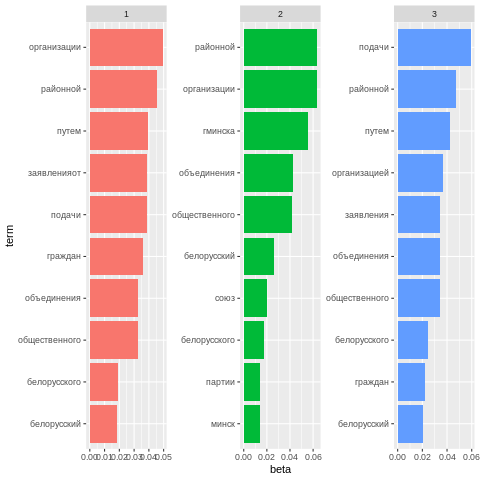

In [379]:
%%R
ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

## Topic Model with Gibbs sampling 

We can also modify our topic model by using gibbs sampling

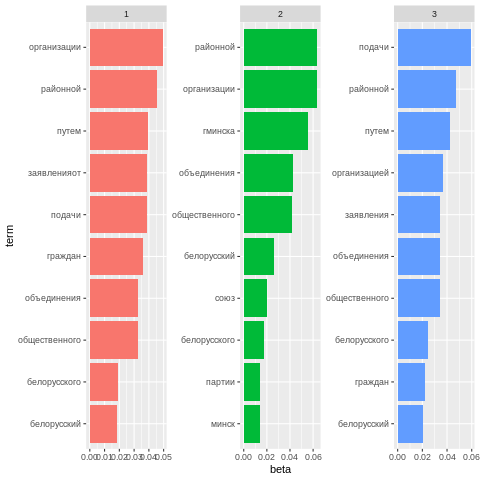

In [380]:
%%R
LDA_G <- LDA(x=dtm, k=2, method="Gibbs",control=list(alpha=1, delta=0.1, seed=10005))
topics_2 <- tidy(LDA_V, matrix ="beta")

ap_top_terms <- topics_2 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

  ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

# Geospatial Analysis (#TODO)

We cal also plot the votes by area. 


In [ ]:
%%R
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')
install.packages('sf')

In [394]:
%%R
#install.packages("rgdal")
#install.packages("sf")
library(sf)

R[write to console]: Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0



In [404]:
%%R
st_drivers()

                         name
PCIDSK                 PCIDSK
netCDF                 netCDF
PDS4                     PDS4
JP2OpenJPEG       JP2OpenJPEG
PDF                       PDF
MBTiles               MBTiles
EEDA                     EEDA
ESRI Shapefile ESRI Shapefile
MapInfo File     MapInfo File
UK .NTF               UK .NTF
OGR_SDTS             OGR_SDTS
S57                       S57
DGN                       DGN
OGR_VRT               OGR_VRT
REC                       REC
Memory                 Memory
BNA                       BNA
CSV                       CSV
NAS                       NAS
GML                       GML
GPX                       GPX
LIBKML                 LIBKML
KML                       KML
GeoJSON               GeoJSON
GeoJSONSeq         GeoJSONSeq
ESRIJSON             ESRIJSON
TopoJSON             TopoJSON
Interlis 1         Interlis 1
Interlis 2         Interlis 2
OGR_GMT               OGR_GMT
GPKG                     GPKG
SQLite                 SQLite
OGR_DODS  

In [412]:
%%R

geo = st_read("BLR_adm2.shp")
road = st_read("BLR_roads.shp")
data <- read_excel("df_merge_d.xlsx")
summary(data)

Reading layer `BLR_adm2' from data source `/content/BLR_adm2.shp' using driver `ESRI Shapefile'
Simple feature collection with 118 features and 11 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 23.19235 ymin: 51.26957 xmax: 32.79461 ymax: 56.16836
geographic CRS: WGS 84
Reading layer `BLR_roads' from data source `/content/BLR_roads.shp' using driver `ESRI Shapefile'
Simple feature collection with 2105 features and 5 fields
geometry type:  MULTILINESTRING
dimension:      XY
bbox:           xmin: 23.2369 ymin: 51.25995 xmax: 32.75626 ymax: 56.12558
geographic CRS: WGS 84


R[write to console]: New names:
* `` -> ...1



      ...1       
 Min.   :   0.0  
 1st Qu.: 395.5  
 Median : 791.0  
 Mean   : 791.0  
 3rd Qu.:1186.5  
 Max.   :1582.0  
 total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election
 Min.   :   0                                                                                                            
 1st Qu.:1318                                                                                                            
 Median :1795                                                                                                            
 Mean   :1719                                                                                                            
 3rd Qu.:2194                                                                                                            
 Max.   :4255                                                                                                            
 number_of_voters_wh

In [ ]:
%%R

merge(geo, data, by.x= region, by.y=region)



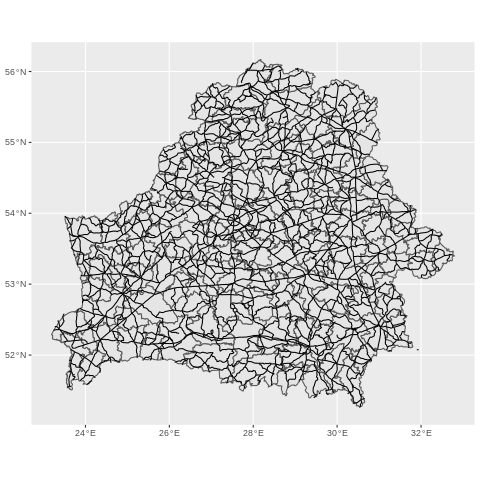

In [411]:
%%R
plot = ggplot()+ geom_sf(data = geo, mapping = aes(geometry = geometry)) + 
  geom_sf(data= road, aes(geometry = geometry)) 
  plot

In [ ]:
%%R


## Appendix 
### Optional: Network Analysis 



In [ ]:
%%R
install.packages("ggraph")
install.packages("igraph")
library(ggraph)
library(igraph)

trigrams_separated <- trigram %>%
  separate(trigram, c("word1", "word2"), sep = " ")

trigrams_filtered <- trigrams_separated %>%
  filter(!word1 %in% c("")) %>%
  filter(!word2 %in% stop_words$word)

# new bigram counts:
trigram_counts <- trigrams_filtered %>% 
  count(word1, word2, sort = TRUE)
trigram_counts
trigram_graph <- trigram_counts %>%
  filter(n > 800) %>%
  graph_from_data_frame()

ggraph(trigram_graph, layout = "fr") +
  geom_edge_link() +
  geom_node_point() +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1)


trigrams_filtered %>%
    filter(!(word1 == "na")) %>%
  filter(!(word2 == "na")) %>%
  count(word1, sort = TRUE)

In [ ]:
%%R
a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(trigram_graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.07, 'inches')) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1) +
  theme_void()

### Feature Importance Random Forest Implementation in R

In [ ]:
%%R

rfo <- ranger(lukashenko_share ~ ., data = data, importance = "permutation")
rfo
vi_rfo <- rfo$variable.importance
vi_rfo
barplot(vi_rfo, horiz = TRUE, las = 1)
vip(rfo, width = 0.5, aesthetics = list(fill = "green3"))


In [195]:
%%R
data <- read_excel("df_merge_d.xlsx")

R[write to console]: New names:
* `` -> ...1



## Exclusion Regions 


In [ ]:
%%R
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen")) # removing other candidate votes
data = select(data, -c("region_no_region", "number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate","...1" ))
# data = select(data, -c("region_brestskaya","region_gomelskaya","region_grodnenskaya", "region_miskaya","region_mogilevskaya","region_vitebskaya"))
colnames(data)[1:12] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")

In [199]:
%%R
data = data %>%
na.omit(lukashenko_share ==0)
data$lukashenko_share

p = ncol(data) -1
n <- nrow(data)

In [221]:
%%R

ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 

model_naive_all_b_minsk = lm(lukashenko_share~.- region_minsk, data = set_train)
model_naive_none = lm(lukashenko_share~.- region_minsk -region_brestskaya - region_grodnenskaya - region_gomelskaya-region_minsk-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_none_b_minsk = lm(lukashenko_share~. -region_brestskaya - region_grodnenskaya - region_gomelskaya-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_all = lm(lukashenko_share~., data = set_train)

## Analysis of Variance for the dummy variables

In [ ]:
%%R
#export_summs(model_naive, model_naive_m)
anova(model_naive_none, model_naive_none_b_minsk, model_naive_all_b_minsk, model_naive_all)